In [1]:
# Library includes
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import random

import requests
import zipfile
from pathlib import Path
import tqdm

# Helper functions

from model_functions import *

from visualize_results import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-Model Comparison Variable
models_and_results = []

In [3]:
# Examine 
def walk_through_dir(dir_path):
    print("in walk through dir")
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

data_path = Path("../data")
image_path = data_path / "CATANIST V2/"
walk_through_dir(image_path)

in walk through dir
There are 2 directories and 1 images in ../data/CATANIST V2
There are 11 directories and 1 images in ../data/CATANIST V2/test
There are 0 directories and 11 images in ../data/CATANIST V2/test/eight
There are 0 directories and 11 images in ../data/CATANIST V2/test/eleven
There are 0 directories and 11 images in ../data/CATANIST V2/test/nine
There are 0 directories and 11 images in ../data/CATANIST V2/test/three
There are 0 directories and 11 images in ../data/CATANIST V2/test/ten
There are 0 directories and 6 images in ../data/CATANIST V2/test/twelve
There are 0 directories and 6 images in ../data/CATANIST V2/test/two
There are 0 directories and 11 images in ../data/CATANIST V2/test/six
There are 0 directories and 4 images in ../data/CATANIST V2/test/desert
There are 0 directories and 11 images in ../data/CATANIST V2/test/five
There are 0 directories and 11 images in ../data/CATANIST V2/test/four
There are 11 directories and 1 images in ../data/CATANIST V2/train
Ther

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../data/CATANIST V2/train'), PosixPath('../data/CATANIST V2/test'))

In [35]:
from torchvision.transforms import v2, transforms

train_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomAffine(degrees=180,translate=(0.1, 0.1),interpolation=transforms.InterpolationMode.BILINEAR),
    v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 1.5))], p=.6),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

test_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    # v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 2))], p=.8),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [36]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)
class_names = train_data.classes

len(train_data), len(test_data), class_names

(1070,
 93,
 ['desert',
  'eight',
  'eleven',
  'five',
  'four',
  'nine',
  'six',
  'ten',
  'three',
  'twelve',
  'two'])

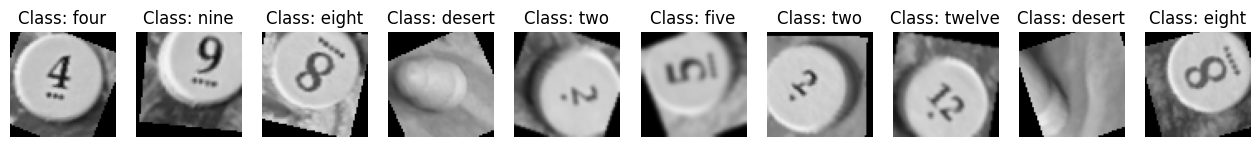

In [45]:
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=10,
                      display_shape=False)

In [46]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x167092690>,
 <torch.utils.data.dataloader.DataLoader at 0x17fe1f990>)

In [47]:
device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

# ResNet Model

In [48]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape: int, output_shape:int, stride=1) -> None:
        super(BasicBlock, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(input_shape, 
                               output_shape, 
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # Batch norm 1
        self.bn1 = nn.BatchNorm2d(output_shape)
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(output_shape, 
                               output_shape,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        # Batch norm 2
        self.bn2 = nn.BatchNorm2d(output_shape)
        
        # Account for differences in stride length if not 1 & num filters
        self.downsample = nn.Sequential()
        if stride != 1 or input_shape != output_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_shape, output_shape,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(output_shape)
            )
    def forward(self, x):
        identity = x
        logits = self.conv1(x)
        logits = self.bn1(logits)
        logits = self.relu(logits)
        logits = self.conv2(logits)
        logits = self.bn2(logits)
        logits += self.downsample(identity)
        logits = self.relu(logits)
        return logits

In [49]:
class ResNet(nn.Module):
    def __init__(self, input_shape, block, layers, class_cnt):
        super(ResNet, self).__init__()
        self.num_classes = class_cnt
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=input_shape, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Create 3 'blocks'
        self.block1 = self.make_layer(block, 64, layers[0], stride=1)
        self.block2 = self.make_layer(block, 128, layers[1], stride=2)
        self.block3 = self.make_layer(block, 256, layers[2], stride=2)
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(256, class_cnt)
    def make_layer(self, block, output_shape, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, output_shape, stride))
        self.in_channels = output_shape
        for _ in range(1, blocks):
            layers.append(block(output_shape, output_shape, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        logits = self.bn1(logits)
        # print(f"x shape after batch norm 1: {x.shape}")
        logits = self.relu(logits)
        logits = self.block1(logits)
        # print(f"x shape after res block 1: {x.shape}")
        logits = self.block2(logits)
        # print(f"x shape after res block 2: {x.shape}")
        logits = self.block3(logits)
        # print(f"x shape after res block 3: {x.shape}")
        logits = self.avg_pool(logits)
        logits = logits.view(logits.size(0), -1)
        logits = self.fc(logits)
        return logits

In [50]:
model = ResNet(input_shape=3, 
               block=BasicBlock,
               layers=[2, 2, 2],
               class_cnt=len(class_names)).to(device)

## Test Image

In [51]:
# Get a single image batch
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape, label_batch.shape
model(image_batch.to(device))

tensor([[-1.7401e-01,  1.1568e-01, -9.3572e-01,  3.5337e-01,  4.0259e-01,
          3.5802e-02, -5.6617e-01, -2.7670e-02,  2.7433e-01,  6.7218e-01,
          4.5722e-02],
        [-2.4055e-01,  1.5700e-01, -8.9040e-01,  3.2874e-01,  3.7240e-01,
         -5.7643e-02, -4.1156e-01, -3.2990e-02,  1.5499e-01,  7.0531e-01,
          1.4534e-02],
        [-2.0660e-01,  1.9872e-01, -8.8989e-01,  3.6163e-01,  3.7357e-01,
          4.5549e-02, -4.3090e-01, -4.4326e-02,  2.4037e-01,  6.7712e-01,
          2.5990e-02],
        [-1.0301e-01,  7.2701e-02, -6.1545e-01,  3.4874e-01,  5.9919e-01,
         -4.2484e-02, -6.2974e-01, -9.5173e-03,  1.7641e-01,  8.6183e-01,
         -1.1086e-01],
        [-1.9300e-01,  4.9406e-02, -6.7822e-01,  2.8887e-01,  2.6530e-01,
         -1.1167e-01, -3.8258e-01,  1.0789e-01,  1.1050e-01,  6.9333e-01,
         -4.3006e-02],
        [-1.5954e-01, -1.7450e-02, -6.8482e-01,  3.9293e-01,  4.9201e-01,
         -5.6788e-02, -5.2029e-01,  3.9040e-02,  2.4875e-01,  7.4475e-0

In [52]:
# Model variables
INPUT_SHAPE = 3
OUTPUT_SHAPE = len(class_names)
# Hyperparameters (Batch size is in cell 10)
EPOCHS = 25
LEARNING_RATE = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

hyperparameters = {"Model Name": "ResNet","Epochs":EPOCHS, "Batch Size": BATCH_SIZE, "Learning Rate":LEARNING_RATE, "Loss Function": LOSS_FN, "Optimizer": optimizer}
hyperparameters

{'Model Name': 'ResNet',
 'Epochs': 25,
 'Batch Size': 32,
 'Learning Rate': 0.001,
 'Loss Function': CrossEntropyLoss(),
 'Optimizer': torch.optim.adam.Adam}

In [53]:
### Train ResNet
model_resnet = ResNet(input_shape=INPUT_SHAPE, 
                    block=BasicBlock,
                    layers=[2, 2, 2],
                    class_cnt=OUTPUT_SHAPE).to(device)

resnet_optimizer = optimizer(model_resnet.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train simple model
model_resnet_results = train(model=model_resnet,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=resnet_optimizer,
                            loss_fn=LOSS_FN,
                            epochs=EPOCHS,
                            device=device)

# End the timer
end_time = timer()
print(f"ResNet training time: {end_time-start_time:.3f} seconds")

# Record results into a list of tuples where each tuple has the hyperparameter dictionary as well as the results
models_and_results.append([hyperparameters, model_resnet_results])

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:04<01:56,  4.84s/it]

Epoch: 1 | train_loss: 1.7665 | train_acc: 0.3363 | test_loss: 2.0291 | test_acc: 0.2608


  8%|▊         | 2/25 [00:09<01:50,  4.80s/it]

Epoch: 2 | train_loss: 1.1015 | train_acc: 0.6200 | test_loss: 1.2811 | test_acc: 0.5223


 12%|█▏        | 3/25 [00:14<01:43,  4.68s/it]

Epoch: 3 | train_loss: 0.7595 | train_acc: 0.7617 | test_loss: 19.3420 | test_acc: 0.1042


 16%|█▌        | 4/25 [00:18<01:36,  4.62s/it]

Epoch: 4 | train_loss: 0.5719 | train_acc: 0.8065 | test_loss: 3.4686 | test_acc: 0.3222


 20%|██        | 5/25 [00:23<01:35,  4.76s/it]

Epoch: 5 | train_loss: 0.5032 | train_acc: 0.8515 | test_loss: 4.9694 | test_acc: 0.2586


 24%|██▍       | 6/25 [00:28<01:29,  4.70s/it]

Epoch: 6 | train_loss: 0.3016 | train_acc: 0.9326 | test_loss: 1.7017 | test_acc: 0.5402


 28%|██▊       | 7/25 [00:32<01:23,  4.64s/it]

Epoch: 7 | train_loss: 0.2763 | train_acc: 0.9301 | test_loss: 3.7098 | test_acc: 0.2626


 32%|███▏      | 8/25 [00:37<01:18,  4.61s/it]

Epoch: 8 | train_loss: 0.2043 | train_acc: 0.9575 | test_loss: 2.7441 | test_acc: 0.3042


 36%|███▌      | 9/25 [00:41<01:13,  4.58s/it]

Epoch: 9 | train_loss: 0.1746 | train_acc: 0.9606 | test_loss: 4.5616 | test_acc: 0.2493


 40%|████      | 10/25 [00:46<01:08,  4.56s/it]

Epoch: 10 | train_loss: 0.1755 | train_acc: 0.9593 | test_loss: 6.3114 | test_acc: 0.2805


 44%|████▍     | 11/25 [00:50<01:03,  4.56s/it]

Epoch: 11 | train_loss: 0.1631 | train_acc: 0.9575 | test_loss: 3.1045 | test_acc: 0.3836


 48%|████▊     | 12/25 [00:55<00:59,  4.55s/it]

Epoch: 12 | train_loss: 0.1456 | train_acc: 0.9623 | test_loss: 2.4779 | test_acc: 0.4307


 52%|█████▏    | 13/25 [00:59<00:54,  4.55s/it]

Epoch: 13 | train_loss: 0.0824 | train_acc: 0.9825 | test_loss: 0.7793 | test_acc: 0.7852


 56%|█████▌    | 14/25 [01:04<00:50,  4.55s/it]

Epoch: 14 | train_loss: 0.0525 | train_acc: 0.9908 | test_loss: 4.4115 | test_acc: 0.4045


 60%|██████    | 15/25 [01:09<00:45,  4.55s/it]

Epoch: 15 | train_loss: 0.0891 | train_acc: 0.9789 | test_loss: 0.8320 | test_acc: 0.6925


 64%|██████▍   | 16/25 [01:13<00:40,  4.55s/it]

Epoch: 16 | train_loss: 0.0622 | train_acc: 0.9890 | test_loss: 1.8072 | test_acc: 0.5776


 68%|██████▊   | 17/25 [01:18<00:36,  4.55s/it]

Epoch: 17 | train_loss: 0.0527 | train_acc: 0.9881 | test_loss: 1.1404 | test_acc: 0.5973


 72%|███████▏  | 18/25 [01:22<00:31,  4.54s/it]

Epoch: 18 | train_loss: 0.0994 | train_acc: 0.9697 | test_loss: 8.2709 | test_acc: 0.2439


 76%|███████▌  | 19/25 [01:27<00:27,  4.54s/it]

Epoch: 19 | train_loss: 0.0964 | train_acc: 0.9814 | test_loss: 4.0411 | test_acc: 0.3897


 80%|████████  | 20/25 [01:31<00:22,  4.53s/it]

Epoch: 20 | train_loss: 0.2385 | train_acc: 0.9216 | test_loss: 9.3094 | test_acc: 0.2805


 84%|████████▍ | 21/25 [01:36<00:18,  4.53s/it]

Epoch: 21 | train_loss: 0.0869 | train_acc: 0.9779 | test_loss: 6.2082 | test_acc: 0.3118


 88%|████████▊ | 22/25 [01:40<00:13,  4.52s/it]

Epoch: 22 | train_loss: 0.0285 | train_acc: 0.9972 | test_loss: 1.1863 | test_acc: 0.6591


 92%|█████████▏| 23/25 [01:45<00:09,  4.52s/it]

Epoch: 23 | train_loss: 0.0207 | train_acc: 0.9991 | test_loss: 1.2293 | test_acc: 0.6297


 96%|█████████▌| 24/25 [01:49<00:04,  4.53s/it]

Epoch: 24 | train_loss: 0.0170 | train_acc: 0.9982 | test_loss: 0.0393 | test_acc: 1.0000


100%|██████████| 25/25 [01:54<00:00,  4.58s/it]

Epoch: 25 | train_loss: 0.0145 | train_acc: 0.9991 | test_loss: 0.2460 | test_acc: 0.9167
ResNet training time: 114.415 seconds


## Results after 25 epochs and normal transform on both test and train data:
- Epoch: 25 | train_loss: 0.0370 | train_acc: 0.9940 | test_loss: 0.0878 | test_acc: 0.9885

## Results after 25 epochs and no guassian blur:
- Epoch: 25 | train_loss: 0.0416 | train_acc: 0.9950 | test_loss: 4.0634 | test_acc: 0.4497

## Results after 25 epochs and less translation in transforms:
- Epoch: 25 | train_loss: 0.0374 | train_acc: 0.9935 | test_loss: 1.1929 | test_acc: 0.6462

## Results after 25 epochs, doubled the 2 and 12 images, and no guassian on test images
- Epoch: 25 | train_loss: 0.0865 | train_acc: 0.9860 | test_loss: 0.8721 | test_acc: 0.7414

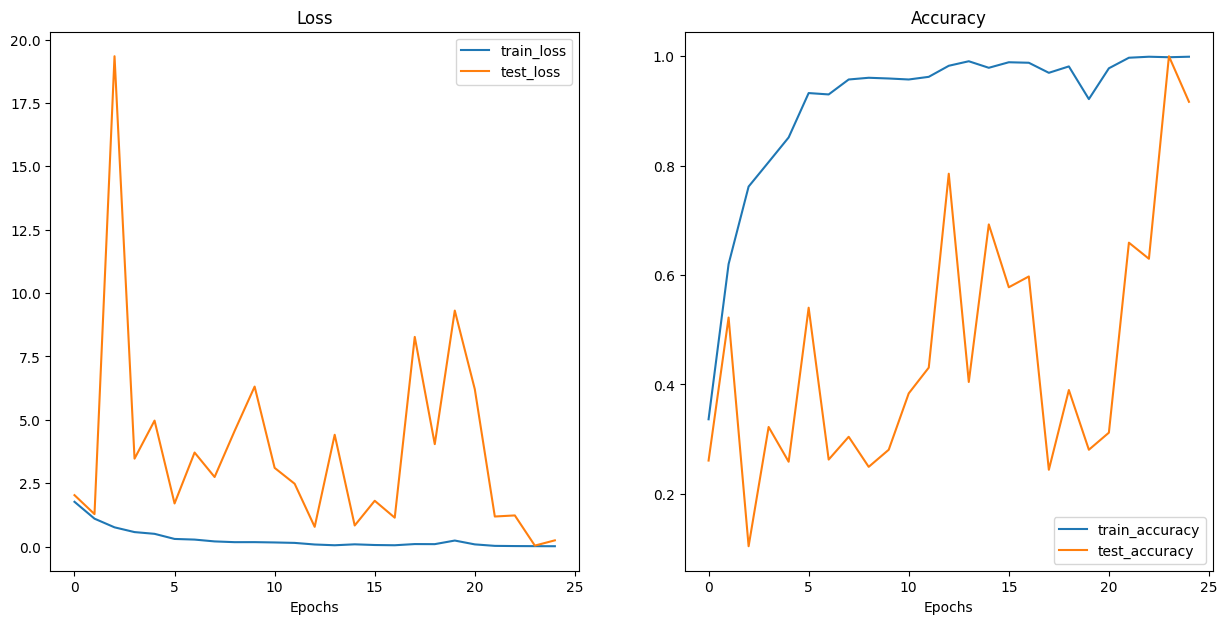

In [54]:
plot_loss_curves(model_resnet_results)

## Test on a custom image

In [55]:
custom_image_path = "../images/eval numbers/007.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=3)
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 60, 60])
New shape: torch.Size([3, 64, 64])


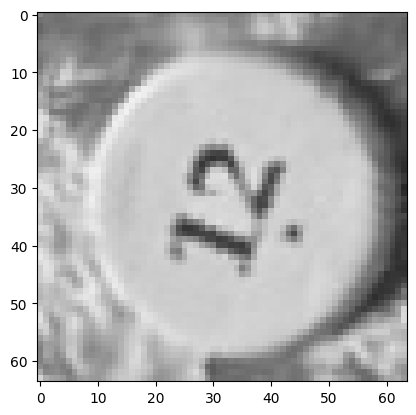

In [56]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [57]:
class_names

['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two']

In [58]:
model_resnet.eval()
with torch.inference_mode():
    custom_image_pred = model_resnet(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction class: {class_names[custom_image_pred_label]}")

Prediction class: twelve


## Save the model

In [59]:
from pathlib import Path 

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "catanistv2_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_resnet.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/catanistv2_2.pth


In [60]:
sorted(['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two'])

['desert',
 'eight',
 'eleven',
 'five',
 'four',
 'nine',
 'six',
 'ten',
 'three',
 'twelve',
 'two']